In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

### Đọc dữ liệu đã được nhóm lấy về trên git repo của nhóm

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/cngthnh/COVID-19_SIR/main/data/VN.csv", parse_dates=True).set_index("time")

confirmed = data['case_by_time']
recovered = data['recovered_by_time']
death = data['death_by_time']

### Hàm mất mát (loss function) để tính mối quan hệ giữa giá trị thực tế và giá trị dự đoán 
Hàm minimize được cài bên trong lớp Learner sẽ tối ưu tham số gamma và beta theo hàm loss này

In [3]:
def loss(point, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta, gamma = point

    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
  
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.099

    return alpha * l1 + (1 - alpha) * l2

### Lớp learner học từ dữ liệu và lưu lại các tham số beta, gamma bên trong lớp để có thể predict lại

In [4]:
class Learner(object):
    def __init__(self, loss, confirmed, recovered, death, start_date, end_date, s_0, i_0, r_0):
        self.loss = loss
        self.start_date = start_date
        self.end_date = end_date
        self.confirmed = confirmed.loc[self.start_date:self.end_date]
        self.recovered = recovered.loc[self.start_date:self.end_date]
        self.death = death.loc[self.start_date:self.end_date]
        self.s_0 = s_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.beta = None
        self.gamma = None
    
    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%d/%m/%Y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%d/%m/%Y'))
        return values

    def predict(self, predict_range):
        data = (self.confirmed - self.recovered - self.death)
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-self.beta*S*I, self.beta*S*I-self.gamma*I, self.gamma*I]

        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        extended_recovered = np.concatenate((self.recovered.values, [None] * (size - len(self.recovered.values))))
        extended_death = np.concatenate((self.death.values, [None] * (size - len(self.death.values))))

        prediction = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1))
        
        df = pd.DataFrame({'Ca nhiễm thực tế': extended_actual, 'Ca hồi phục thực tế': extended_recovered, 'Ca tử vong thực tế': extended_death, 'Người có khả năng nhiễm': prediction.y[0], 'Dự đoán ca nhiễm': prediction.y[1], 'Dự đoán ca hồi phục': prediction.y[2]}, index=new_index)
        
        # Plot 
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title("Vietnam")
        ax.set_xlabel('Ngày')
        ax.set_ylabel('Số lượng')
        df.plot(ax=ax)
        print("beta=%.8f, gamma=%.8f, r_0=%.8f" %(self.beta, self.gamma, self.beta/self.gamma))

        plt.show()

    def train(self):
        data = (self.confirmed - self.recovered - self.death)
        
        optimal = minimize(loss, [0.001, 0.001], args=(data, self.recovered, self.s_0, self.i_0, self.r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.4), (0.00000001, 0.4)])
        print(optimal)
        self.beta, self.gamma = optimal.x

### Khởi tạo các giá trị ban đầu 

In [5]:
start_date = "11/07/2021"
end_date = "25/08/2021"
s_0 = 600000
i_0 = 4000
r_0 = 200

### Huấn luyện

In [6]:
learner = Learner(loss, confirmed, recovered, death, start_date, end_date, s_0, i_0, r_0)
learner.train()

      fun: 18086.64440541535
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.61969422e+10, -2.47893575e+04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 351
      nit: 35
     njev: 117
   status: 0
  success: True
        x: array([2.92696008e-07, 4.90499130e-02])


### Dự đoán

beta=0.00000029, gamma=0.04904991, r_0=0.00000597


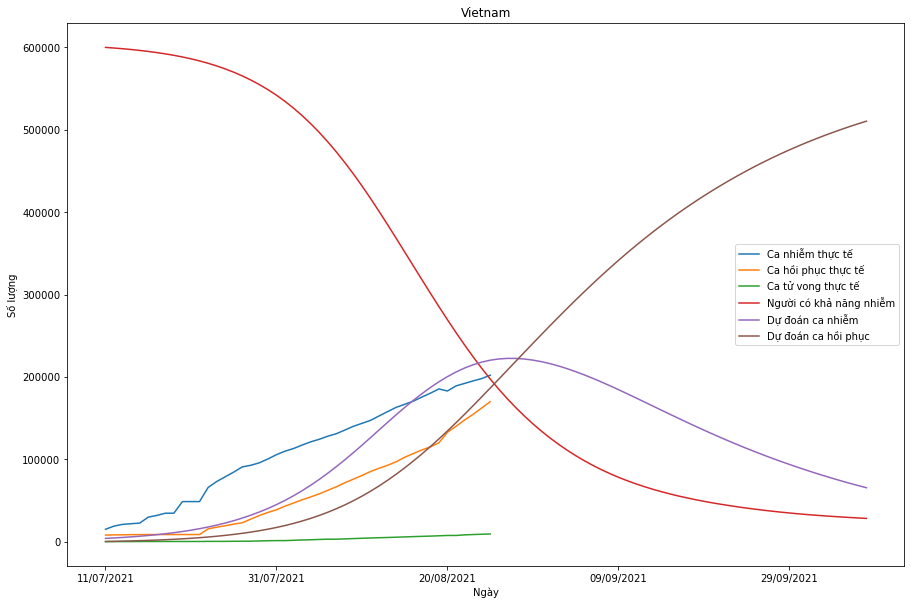

In [7]:
learner.predict(90)